In [1]:
import pandas as pd
from neuralforecast.core import NeuralForecast
from neuralforecast.models import TimesNet
import matplotlib.pyplot as plt

c:\Users\scree\.conda\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-15 17:26:16,759	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-07-15 17:26:16,862	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [10]:
import pandas as pd

# Загрузка файла и преобразование столбца date к формату datetime
df = pd.read_csv('dataset_bar_harmonics_median.csv', parse_dates=['date'])

# Отсечение данных после 1 июля 2025 включительно
cutoff_date = pd.Timestamp('2025-07-01')
filtered_df = df[df['date'] <= cutoff_date]

# Сохранение или дальнейшая работа
filtered_df.to_csv('dataset_bar_harmonics_median_filtered.csv', index=False)


In [2]:
# Загрузка вашего файла
df = pd.read_csv('dataset_bar_harmonics_median_filtered.csv', parse_dates=['date'])

# Преобразуем к нужному формату
df = df.rename(columns={'date': 'ds', 'value': 'y'})
df['unique_id'] = 'id_1'  # один временной ряд

# Проверка
print(df.head())


                   ds         y unique_id
0 2024-04-01 11:09:40  2.344165      id_1
1 2024-04-02 03:44:22  2.182038      id_1
2 2024-04-03 00:00:16  2.249901      id_1
3 2024-04-04 02:02:31  2.256531      id_1
4 2024-04-06 03:08:05  2.347752      id_1


In [3]:
horizon = 24          # горизонт прогноза (выберите под свою задачу)
input_size = 300       # размер окна истории (обычно в 2–4 раза больше горизонта)

In [ ]:

# Инициализация модели
model = TimesNet(
    h=horizon,
    input_size=input_size,
    max_steps=200,
    learning_rate=1e-3,
    scaler_type='standard'
)

# Определение контейнера моделей (важно указать freq вашей серии)
nf = NeuralForecast(models=[model], freq='D')  # или 'H', если данные почасовые

# Обучение модели
nf.fit(df=df)


Seed set to 1
c:\Users\scree\.conda\envs\myenv\lib\site-packages\neuralforecast\common\_base_model.py:537: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080 SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0 

Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s, v_num=7, train_loss_step=0.610, train_loss_epoch=0.610]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s, v_num=7, train_loss_step=0.610, train_loss_epoch=0.610]


In [5]:
forecast_df = nf.predict()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


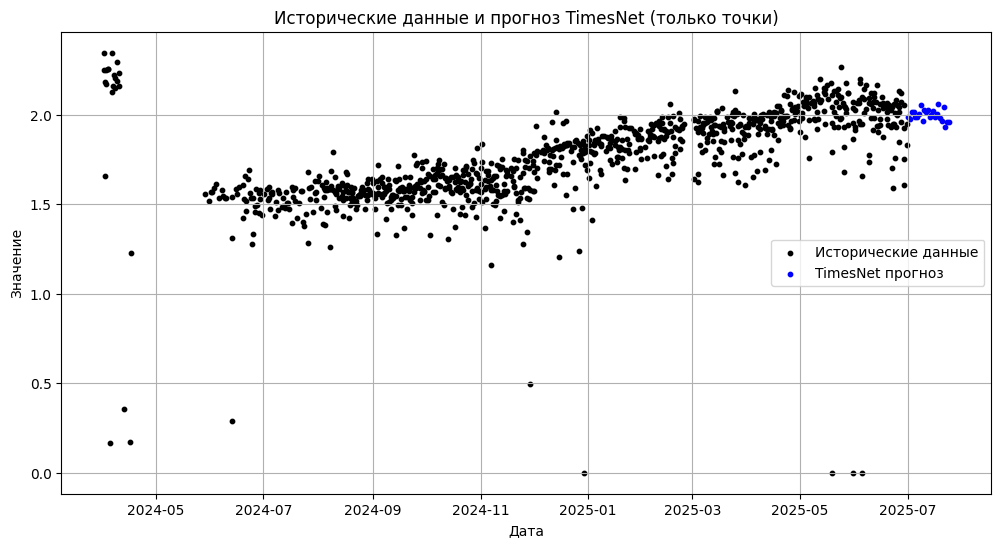

In [6]:
actual = df.set_index('ds')['y']
forecast = forecast_df.set_index('ds')['TimesNet']

plt.figure(figsize=(12, 6))
plt.scatter(actual.index, actual.values, color='black', label='Исторические данные', s=10)
plt.scatter(forecast.index, forecast.values, color='blue', label='TimesNet прогноз', s=10)
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Исторические данные и прогноз TimesNet (только точки)')
plt.legend()
plt.grid(True)
plt.show()